In [2]:
%pylab inline
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-greater-05
#/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-less-05

In [3]:
factors = ['BHLHE40','CEBPB','CTCF','E2F4','EBF1','ELF1','ELK1','ETS1','FOS','IRF4','JunD','Max','MEF2A','MEF2C','Mxi1','NFIC','NFKB','NFYA','NFYB','Nrf1','NRSF','PAX5','PBX3','POU2F2','PU1','RFX5','RUNX3','SP1','SRF','STAT1','STAT3','TCF3','USF1','USF2','YY1','ZBTB33','ZEB1','Znf143']
orcols = ["OR_%s"%f for f in factors]

def LoadKmer(fpath):
    max_kmers = [] # keep track of best kmers for each factor
    fdata = pd.read_csv(fpath%factors[0], sep="\t", usecols=[0,1,2], names=["kmer","pval_%s"%factors[0],"OR_%s"%factors[0]])
    max_kmers.append(fdata.sort_values("OR_%s"%factors[0], ascending=False)["kmer"].values[0])
    for i in range(1, len(factors)):
        ff = pd.read_csv(fpath%factors[i], sep="\t", usecols=[0,1,2], names=["kmer","pval_%s"%factors[i],"OR_%s"%factors[i]])
        fdata = pd.merge(ff, fdata, on=["kmer"], how="right")
        max_kmers.append(fdata.sort_values("OR_%s"%factors[i], ascending=False)["kmer"].values[0])
    max_kmers = set(max_kmers)
    ORdata = fdata[["kmer"]+orcols]
    ORdata.index = ORdata["kmer"]
    max_kmers = max_kmers.union(set(ORdata["kmer"][ORdata[orcols].apply(max, 1)>10]))
    return ORdata, max_kmers

In [4]:
fpath = "/storage/pandaman/project/AgentBind-GM12878-analysis/results/c/%s+GM12878/kmer_ranking.txt"
ORdata, max_kmers = LoadKmer(fpath)

fpath_good = "/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-less-05/c/%s+GM12878/kmer_ranking.txt"
ORdata_good, max_kmers_good = LoadKmer(fpath_good)

fpath_bad = "/storage/pandaman/project/AgentBind-GM12878-analysis/results-pval-greater-05/c/%s+GM12878/kmer_ranking.txt"
ORdata_bad, max_kmers_bad = LoadKmer(fpath_bad)

/home/mgymrek/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


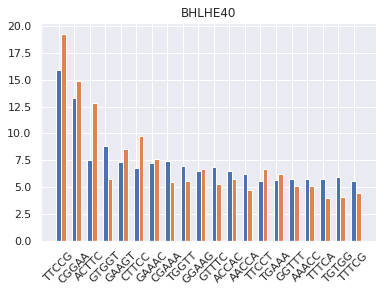

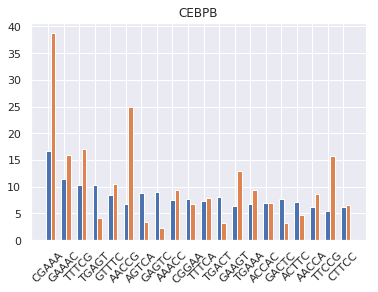

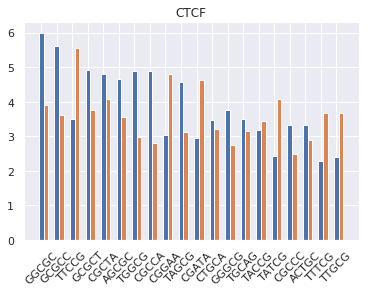

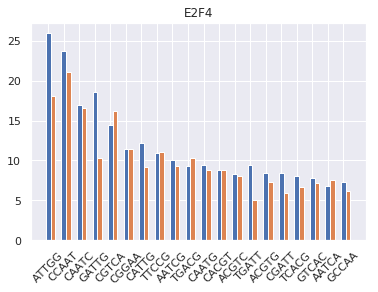

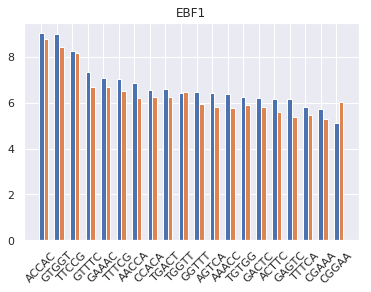

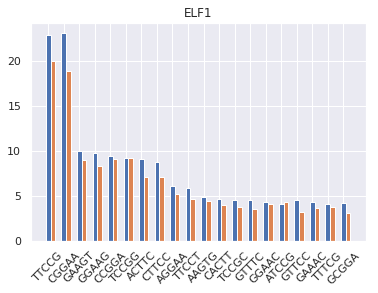

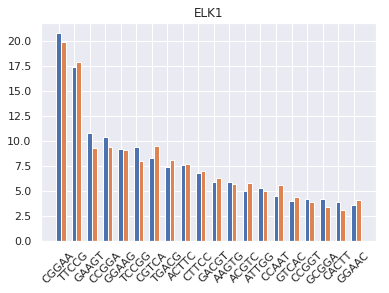

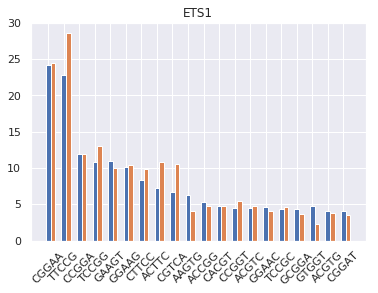

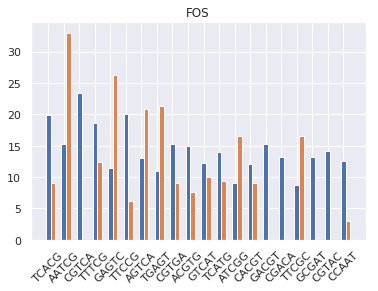

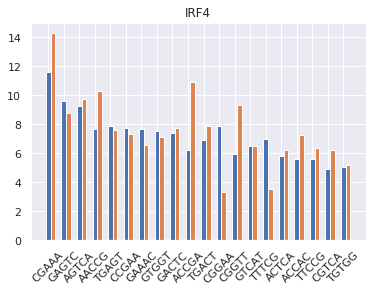

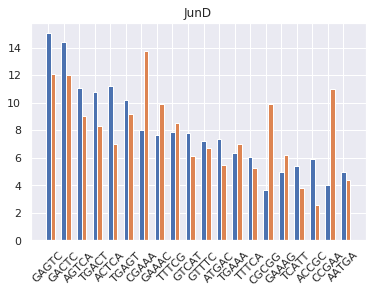

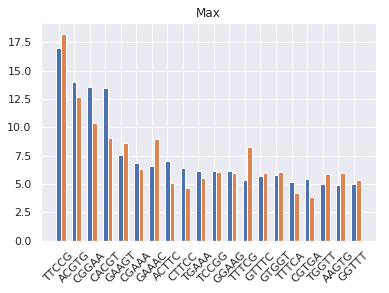

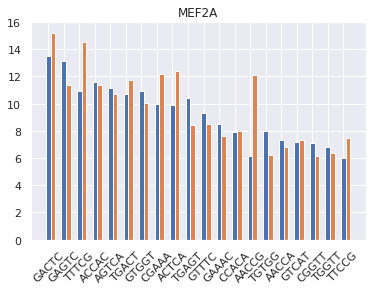

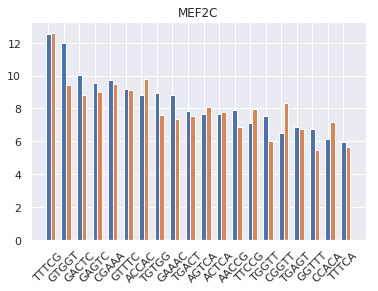

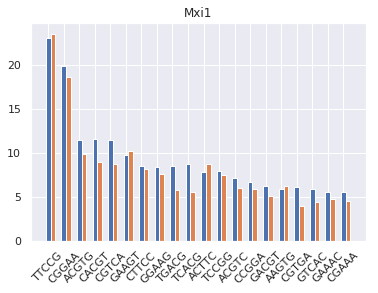

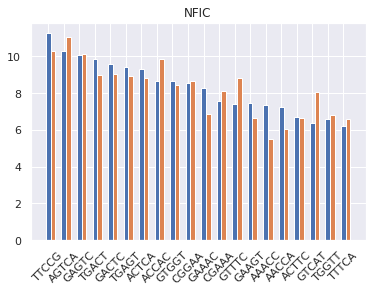

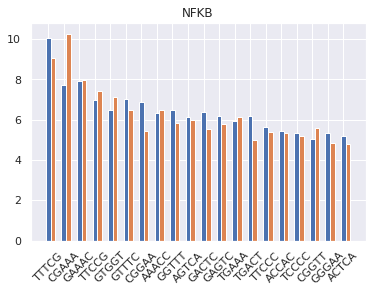

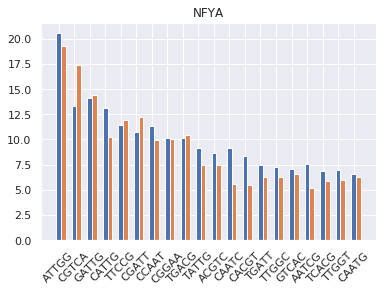

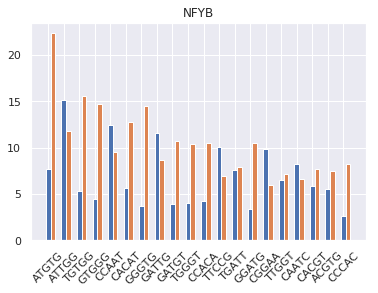

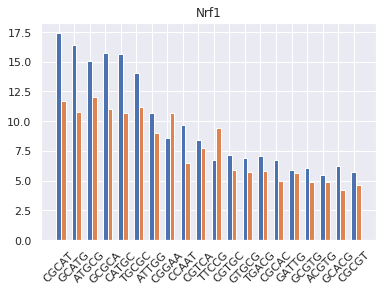

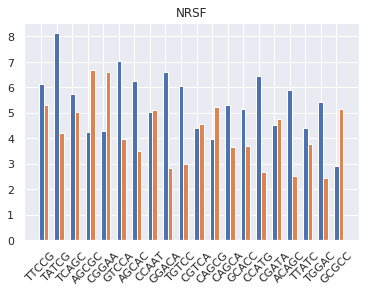

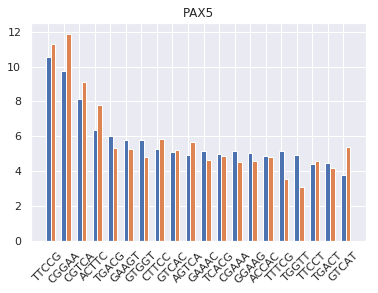

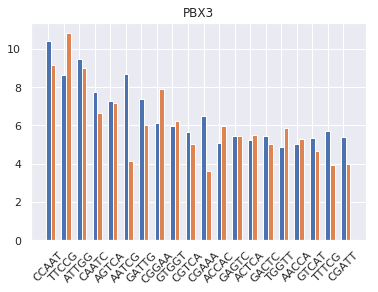

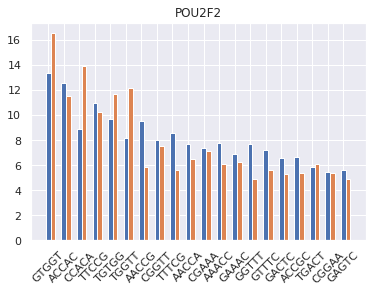

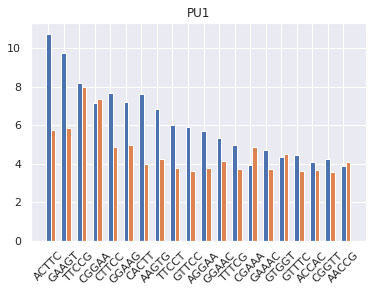

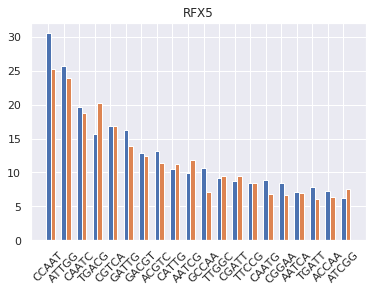

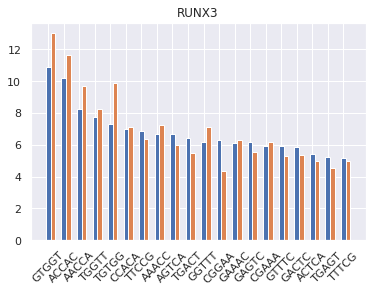

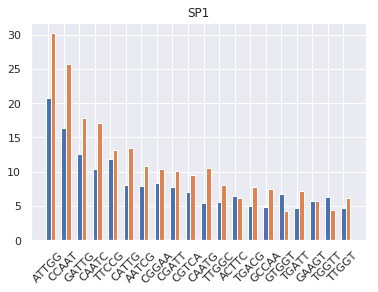

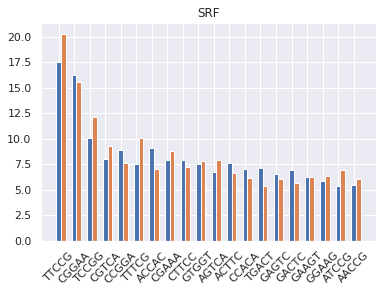

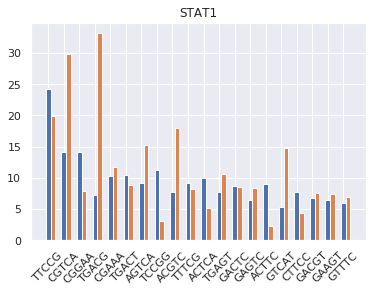

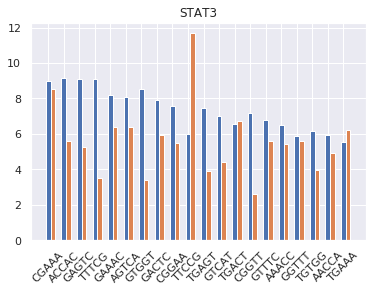

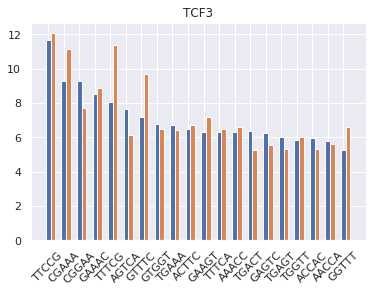

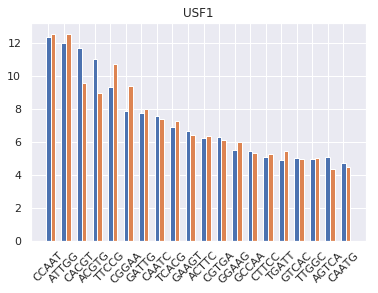

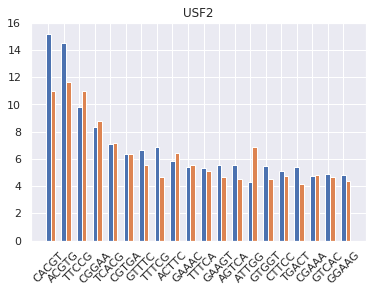

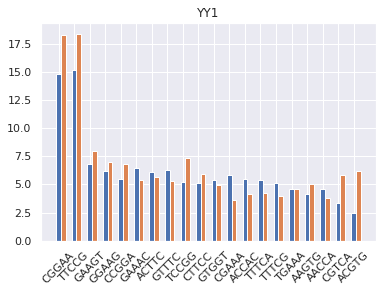

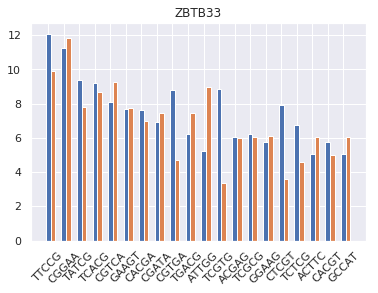

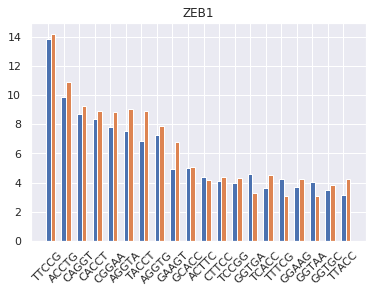

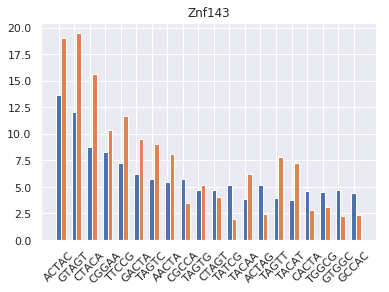

In [7]:
merged = pd.merge(pd.merge(ORdata_bad, ORdata_good, on=["kmer"], suffixes=("_bad","_good")), ORdata, on=["kmer"])

for factor in factors:
    xx = merged[["kmer","OR_%s_good"%factor,"OR_%s_bad"%factor,"OR_%s"%factor]]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xx = xx.sort_values("OR_%s"%factor, ascending=False).head(n=20)
    w = 0.3
    ax.bar(range(xx.shape[0]), xx["OR_%s_bad"%factor], width=w)
    ax.bar([item+w for item in range(xx.shape[0])], xx["OR_%s_good"%factor], width=w)
    ax.set_title(factor)
    ax.set_xticks(range(xx.shape[0]))
    ax.set_xticklabels(xx["kmer"], rotation=45)

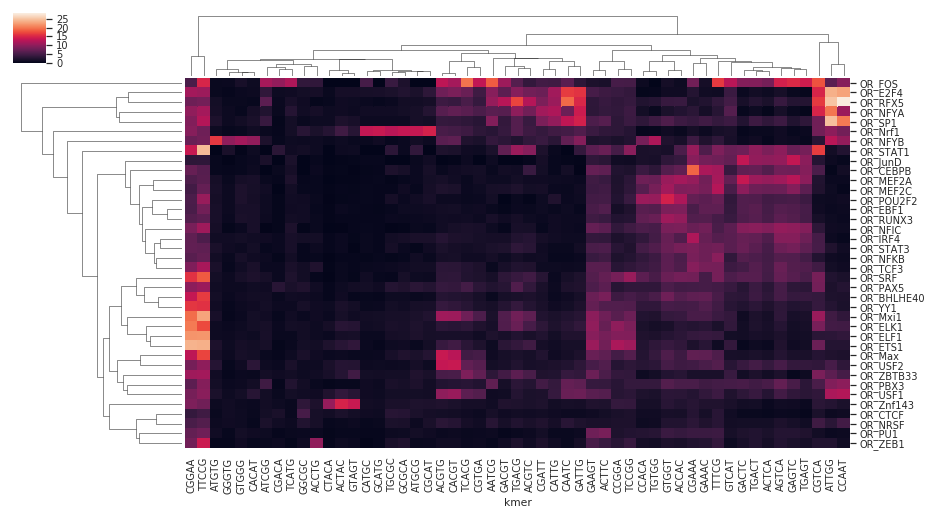

In [6]:

sns.set(font_scale=0.9)
g = sns.clustermap(ORdata[ORdata["kmer"].apply(lambda x: x in max_kmers)][orcols].transpose(),
                   yticklabels=True, xticklabels=True, figsize=(15, 8))

In [14]:
ORdata

,kmer,OR_BHLHE40,OR_CEBPB,OR_CTCF,OR_E2F4,OR_EBF1,OR_ELF1,OR_ELK1,OR_ETS1,OR_FOS,...,OR_SRF,OR_STAT1,OR_STAT3,OR_TCF3,OR_USF1,OR_USF2,OR_YY1,OR_ZBTB33,OR_ZEB1,OR_Znf143
0,ACTAC,1.104317,0.426530,1.988996,1.645970,0.877966,1.634916,3.073397,3.074978,0.000000,...,0.744258,0.899534,0.774339,0.724744,3.644466,2.778727,1.914124,2.813962,1.014249,14.922246
1,GTAGT,0.526485,0.218418,1.508663,1.577432,0.564225,1.701870,2.763148,3.577236,0.000000,...,0.384657,1.099534,0.128671,0.526491,2.908231,2.728091,1.456517,4.812308,0.799611,13.819963
2,CTACA,0.530494,0.298879,1.392321,0.710529,0.308311,0.877426,1.583518,2.245821,0.000000,...,0.218726,0.000000,0.448969,0.286479,2.388627,1.927052,1.059175,1.811792,0.503925,10.492357
3,CGGAA,13.583912,7.503142,3.904827,11.454280,5.487910,21.977460,20.382157,24.162058,5.507235,...,16.109524,13.808788,7.134223,9.076311,8.519056,8.494670,16.333985,11.234002,8.179742,8.977325
4,TTCCG,16.666229,6.348432,4.651914,10.993018,8.256968,22.168568,17.550062,23.909894,15.169209,...,18.512612,24.612684,6.904596,11.711761,9.816808,10.077383,16.100402,11.420293,14.016202,8.159083
5,GACTA,1.428127,3.638228,0.489080,1.495891,1.820707,0.775345,1.803554,1.450737,1.767776,...,1.854502,2.302467,2.071905,1.968093,2.866367,2.374833,1.514721,0.915203,0.997112,6.964420
6,TAGTC,1.562690,2.471274,0.378551,0.776636,1.619255,0.910381,1.716921,1.766384,0.000000,...,2.056461,4.504437,1.998190,2.074651,2.913464,2.792768,1.397319,1.681147,0.652953,6.274117
7,AACTA,1.538848,1.231848,0.837244,0.925739,0.990985,1.040618,1.177369,1.810244,0.000000,...,0.900282,0.875640,0.613063,0.871360,1.225665,1.524413,1.132078,2.074309,0.400008,6.222372
8,CGCCA,1.404317,0.735916,3.982105,3.068756,0.979087,2.099364,2.269267,2.471468,1.833291,...,1.534715,1.178188,2.063314,1.546505,1.633581,1.486973,2.791381,3.112218,2.065415,5.092466
9,TAGTG,1.279245,0.206555,1.953042,0.426165,1.047204,0.932937,0.742031,0.502907,0.000000,...,0.970109,0.000000,0.962174,0.864417,0.763440,0.904615,1.534250,0.810784,0.631589,4.760778
